In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np


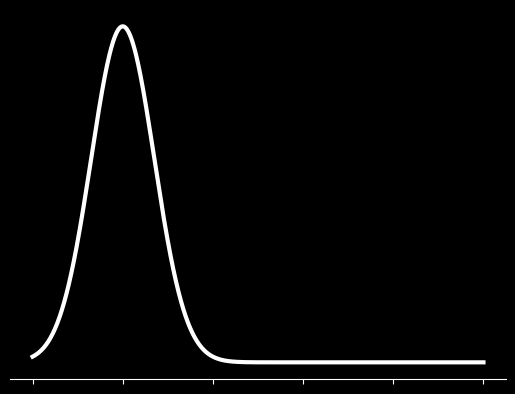

<Figure size 200x300 with 0 Axes>

In [2]:
u = 20
sigma = 7

x = np.linspace(0,100,1000)
y = np.exp(-(x-u)**2/2/sigma**2)


plt.figure(facecolor="black")
ax = plt.axes()
ax.get_yaxis().set_visible(False)
ax.xaxis.label.set_color('white') 
ax.spines['bottom'].set_color('#ffffff')
ax.tick_params(axis='x', colors='white', labelbottom=False)    
rcParams['axes.linewidth'] = 3
#plt.xticks(c ="white")
#ax.set_axis_off()
ax.set_facecolor("black")
ax.plot(x,y,c="white",linewidth=3)
plt.figure(figsize = (2,3))
plt.savefig("Gaussian P")


In [3]:
'''
TODO
[x] Add 3D
[] Add time_slice identification to each photon
[] Examine data and identify source of abnormally large vectors.
[x] Add polarisation
[o] Complete compton process
    [] Energy change
    [] Polarisation change
[] Detection process
    [] Energy blurring
    [] Position blurring
[] Pairing and noting event
[] 
'''


import numpy as np
import vector as vc
import scipy as sc
import matplotlib.pyplot as plt
import copy

# Constants
hbar = 4.135667696e-15 # eV / Hz
# from scipy.constants import hbar
c = 299792458 # m/s
# I don't think we need to include this since I want the normalised probability distribution.
classical_electron_radius = 1 # 2.8179403262e-15 # m

# Times and source activities
time_slice = 1 # nanoseconds
time_window = 10 # nanoseconds
total_time = 10**3 # nanoseconds
n_windows = total_time//time_window

source_activity_slice = 0.8 # nanoBecquerel - disintegrations per nanosecond
source_activity_window = source_activity_slice*time_window/time_slice

# Compton ring
compton_probability = 0.2
compton_radius = 100 # mm


# Detection Ring

def unpack_cart(vector:vc.obj):
    return (vector.x, vector.y, vector.z)

def cross_product(v1:vc.obj, v2:vc.obj):
    if v1==v2:
        return 0
    elif v1.theta == 0:
        cross = v1.cross(v2)

# Without polarisation case - incomplete
# def Klein_Nishina_Distribution(theta, relative_energy):
#     if abs(theta)>np.pi:
#         return 0
#     elif abs(theta)<=1/np.sqrt(relative_energy):
#         return classical_electron_radius**2
#     else:
#         return

# With Polarisation, Klein-Nishima
def Differential_Cross_Section(theta, phi, relative_energy):
    # Phi has to be relative to polarisation angle
    lambda_ratio = 1/(1+relative_energy*(1-np.cos(theta)))
    return (classical_electron_radius*lambda_ratio)**2/2*(lambda_ratio+1/lambda_ratio-2*np.sin(theta)**2*np.cos(phi)**2)
    
def Sampling_Klein_Nishima(relative_energy):
    # Choose theta based on Gaussian and phi uniformly
    # Do probability check with differential cross section (times dOmega) to and repeat if not true
    if relative_energy==1.0:
        total_cross_section = 3.608457130285029 # Precaculated for the common case
    else:
        total_cross_section = sc.integrate.dblquad(lambda theta, phi: Differential_Cross_Section(theta, phi, relative_energy)*np.sin(theta),
                                                   0,2*np.pi,
                                                   lambda x:0,lambda x:np.pi)[0]
    
    KN_PDF = lambda theta, phi : Differential_Cross_Section(theta, phi, relative_energy)*np.sin(theta)/total_cross_section
    # We want to perform rejection sampling, so we want to find a gaussian which completely covers the PDF
    # Furthermore, PDF has max values at phi = pi/2, so we'll just cover that and assume phi is covered uniformly.
    
    # Finding max of KN_PDF to centre gaussian cover
    if relative_energy==1.0:
        mean = 0.806
        rejection_scale = 0.45 # Precaculated for the common case
    else:
        check_values_at = np.linspace(0,np.pi/2,20)
        max_index = np.argmax(KN_PDF(check_values_at,np.pi/2))
        mean = check_values_at[max_index] # Want to find peak of distribution to within 0.15 radians
        # sigma^2 = pi/2, mean at peak, scaling constant should be A, A/sqrt(2pisigma^2)=1.2*KN_PDF(mean), and sqrt(2pisigma^2)=1
        rejection_scale = 1.2*KN_PDF(mean,np.pi/2)

    sigma = np.sqrt(np.pi/2)
    # sampling

    gaussian = sc.stats.norm(loc = mean, scale = sigma)
    
    while True:
        theta_try = sigma*np.random.randn()+mean
        phi_try = np.random.uniform(0,2*np.pi)
        p = np.random.uniform(0,rejection_scale*gaussian.pdf(theta_try)/(2*np.pi)) # Max value is cover_PDF(theta)*cover_PDF(phi)
        if p<=KN_PDF(theta_try, phi_try):
            return (theta_try, phi_try)

class Gamma:
    def __init__(self, source_pos:vc.obj, source_direction:vc.obj, source_pol:vc.obj):
        # Source coordinates and direction, angles in radians
        self.source_pos = source_pos
        self.source_direction = source_direction
        self.source_polarisation = source_pol

        # Maybe useful, last/current interaction coordinates and direction
        self.last_pos = source_pos
        self.direction = source_direction
        self.polarisation = source_pol

        self.energy = 511e3 # eV
        self.compton_happened = False
        self.compton_loc:vc.obj
    
    def frequency(self): # Hz
        return self.energy/hbar
    
    def wavelength(self): # m
        return c/self.frequency()

    def momentum(self): # eV/c
        return self.energy/c
    
    def setEnergy(self,energy):
        self.energy = energy

    def compton(self, r:float,debug=False): # Might replace r with full location vector
        # Set some variables
        self.compton_happened = True
        epsilon = self.energy/(511e3)
        theta = self.direction.theta
        phi = self.direction.phi
        self.compton_loc = vc.obj(rho=r,theta=theta, phi=phi)

        delta_theta, delta_phi = Sampling_Klein_Nishima(epsilon)
        # print(delta_theta,delta_phi)
        original_direction = copy.deepcopy(self.direction)
        rotation_axis = original_direction.cross(self.polarisation)
        # if rotation_axis
        if debug:
            print(self.direction, self.polarisation, original_direction.cross(self.polarisation))
        self.direction = self.direction.rotate_axis(original_direction.cross(self.polarisation),delta_theta)
        self.direction = self.direction.rotate_axis(original_direction, delta_phi)

        self.energy = self.energy/(1+epsilon*(1-np.cos(delta_theta)))

        # In compton, direction changes, energy changes, polarisation changes.
        

    def detect(self):
        pass
'''
Photon created
Pair by identity or location + time? Going with location + time

'''

hatz = vc.obj(x=0,y=0,z=1)
hatx = vc.obj(x=1,y=0,z=0)


for window in range(n_windows):
    source_activity = int(source_activity_window)
    if np.random.random(1)<(source_activity_window - source_activity): # The difference is the probability of one more event this window
        source_activity+=1
    
    photons = np.empty([2*source_activity], dtype = Gamma)
    # origins = 
    directions_theta = np.pi*np.random.random(source_activity)
    directions_phi = 2*np.pi*np.random.random(source_activity)
    polarisation_phi = 2*np.pi*np.random.random(source_activity)

    for i in range(source_activity):
        direction = vc.obj(rho=1,theta=directions_theta[i], phi=directions_phi[i])

        # Make perpendicular vector for polarisation
        polarisation = direction.cross(hatz)
        if direction.is_parallel(hatz) or direction.is_antiparallel(hatz):
            polarisation = direction.cross(hatx)
        # Randomise it
        polarisation = polarisation.rotate_axis(direction, polarisation_phi)

        photons[2*i] = Gamma(vc.obj(x=0,y=0,z=0),
                             direction,
                             polarisation)
        
        # Each event generates two photons back to back and with perpendicular polarisations
        photons[2*i+1] = Gamma(vc.obj(x=0,y=0,z=0),
                               -direction,
                               polarisation.rotate_axis(direction, np.pi/2))
    

    for i in range(source_activity): # Only the second photon will ever compton scatter, because the distributions are exactly symmetrical
        # If compton happening, calculate where, tell compton event to calculate where it's going now.
        if np.random.random(1)<compton_probability:
            photon = photons[2*i]
            # x = photon.x # RN they're all 0, so
            # y = photon.y
            # z = photon.z
            # theta = photon.theta
            # phi = photon.phi

            # solve (x+r*cos(theta)sin(phi))**2 + (y+r*sin(theta)sin(phi))**2 + (z+r*cos(phi))**2 = compton_r

            photon.compton(compton_radius) # Later will make compton location
        
    


In [20]:
source_activity = int(source_activity_window)
if np.random.random(1)<(source_activity_window - source_activity): # The difference is the probability of one more event this window
    source_activity+=1

photons = np.empty([2*source_activity], dtype = Gamma)
# origins = 
directions_theta = np.pi*np.random.random(source_activity)+0.00000001
directions_phi = 2*np.pi*np.random.random(source_activity)
polarisation_phi = 2*np.pi*np.random.random(source_activity)

for i in range(source_activity):
    direction = vc.obj(rho=1,theta=directions_theta[i], phi=directions_phi[i])

    # Make perpendicular vector for polarisation
    polarisation = direction.cross(hatz)
    if direction.is_parallel(hatz) or direction.is_antiparallel(hatz):
        polarisation = direction.cross(hatx)
    # Randomise it
    polarisation = polarisation.rotate_axis(direction, polarisation_phi)

    photons[2*i] = Gamma(vc.obj(x=0,y=0,z=0),
                            direction,
                            polarisation)
    
    # Each event generates two photons back to back and with perpendicular polarisations
    photons[2*i+1] = Gamma(vc.obj(x=0,y=0,z=0),
                            -direction,
                            polarisation.rotate_axis(direction, np.pi/2))

[ 0.31145644 -0.62072085 -0.10329889 -0.63145894  0.87346835  0.46042388
  0.76357243  0.11323381]


/opt/homebrew/lib/python3.11/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


ValueError: setting an array element with a sequence.

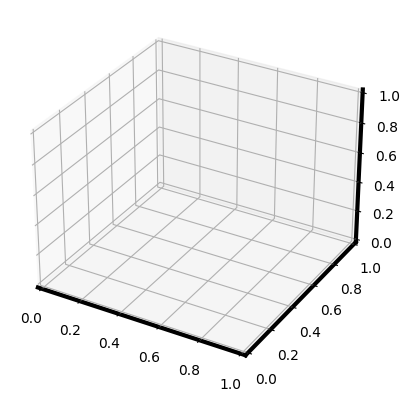

In [21]:

from mpl_toolkits.mplot3d import axes3d, Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax2 = fig.add_subplot()


n_photons = len(photons)


all_vectors = [[],[],[]]
origins = [[],[],[]]

source_angles=[[],[]]
new_angles=[[],[]]
compton_location_angles = [[],[]]

# print(photons[0].direction.phi)

small_radius = 5
for i in range(len(photons)):
    photon = photons[i]
    photon.compton(small_radius)

    source_angles[0].append(photon.source_direction.theta)
    source_angles[1].append(photon.source_direction.phi)
    new_angles[0].append(photon.direction.theta)
    new_angles[1].append(photon.direction.phi)
    compton_location_angles[0].append(photon.compton_loc.theta)
    compton_location_angles[1].append(photon.compton_loc.phi)

    all_vectors[0].append(photon.source_direction.x)
    origins[0].append(0)
    all_vectors[0].append(photon.direction.x)
    origins[0].append(photon.compton_loc.x)
    
    all_vectors[1].append(photon.source_direction.y)
    origins[1].append(0)
    all_vectors[1].append(photon.direction.y)
    origins[1].append(photon.compton_loc.y)

    all_vectors[2].append(photon.source_direction.z)
    origins[2].append(0)
    all_vectors[2].append(photon.direction.z)
    origins[2].append(photon.compton_loc.z)

print(all_vectors[0][1])
ax.quiver(*origins, *all_vectors,
          length=1)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = small_radius*np.cos(u)*np.sin(v)
y = small_radius*np.sin(u)*np.sin(v)
z = small_radius*np.cos(v)
ax.plot_wireframe(x, y, z, color="red", alpha = 0.3)


# ax2.scatter(source_angles[0],source_angles[1], c='b')
# ax2.scatter(new_angles[0],new_angles[1],c='r')
# ax2.scatter(compton_location_angles[0],compton_location_angles[1],c='g')
# ax2.xlabel="theta"
# ax2.ylabel="phi"
# ax.set_xlim3d(-8,8)
# ax.set_ylim3d(-8,8)
# ax.set_zlim3d(-8,8)

plt.show()

In [22]:
photon = Gamma(vc.obj(x=0,y=0,z=0),
               vc.obj(rho=1,theta=np.pi/2,phi=0),
               vc.obj(rho=1,theta=1,phi=0))



2.418044582139089


In [72]:
photon.compton(small_radius)
print(photon.direction)

VectorObject3D(x=0.7645759736877509, y=0.641721842517393, z=0.060138650596088944)


In [19]:
vc.obj(rho=1,theta=np.pi/2,phi=0).cross(vc.obj(rho=1,theta=0.0001,phi=0))

VectorObject3D(x=0.0, y=-9999.999966666666, z=0.0)

In [17]:
vc.obj(rho=1,theta=0.001,phi=0).z

999.9996666666443